In [1]:
import sys
import ccxt
import time
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import math
import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

### Upload Historical Data

In [ ]:
def split_symbols(symbols):
    splitted_symbols = []
    for symbol in symbols:
        if symbol[-3:] in ['ETH', 'BTC']:
            splitted_symbols.append(symbol[:-3] + '/' + symbol[-3:])
        elif symbol[-4:] == 'USDT':
            splitted_symbols.append(symbol[:-4] + '/' + symbol[-4:])
    return splitted_symbols

In [2]:
import glob
paths = [f for f in glob.glob("/Users/alex/Documents/jupyter notebooks/binance_daily_data/*.csv")]
symbols = [path.split('/')[6][:-4] for path in paths]

In [3]:
def get_pairs(paths):
    pairs = []
    for path in paths:
        pair = pd.read_csv(path, index_col = 0)
        pair.drop(['volume', 'open', 'low', 'high'], 1, inplace=True)
        pair['date'] = pd.to_datetime(pair.index)
        pair = pair.set_index('date')
        pair = pair.loc['2018-03-26':'2021-01-25']
        ticker = path.split('/')[6][:-4]
        pair.columns = [ticker]
        pairs.append(pair)
    pairs = pd.concat(pairs, axis=1)
    return pairs

In [4]:
def get_prices(paths):
    pairs = []
    for path in paths:
        pair = pd.read_csv(path, index_col = 0)
        symbol = path.split('/')[6][:-4]
        pair['ticker'] = [symbol for _ in range(len(pair))]
        pairs.append(pair)
    prices = pd.concat(pairs)
    prices['date'] = prices.index
    prices = prices.set_index(['ticker', 'date'])
    return prices

In [5]:
pairs = get_pairs(paths)
pairs.head()

,LSKBTC,MANAETH,VIBETH,QLCETH,ZECETH,VIABTC,TRXETH,WAVESBTC,XRPETH,KMDETH,...,BRDETH,AMBBTC,ONTETH,LTCBTC,LRCETH,NANOETH,NEOUSDT,AEETH,ETCETH,XZCETH
date,,,,,,,,,,,,,,,,,,,,,
2018-03-26 07:00:00,0.001336,0.000174,0.000323,0.000316,0.46131,0.000182,0.000090,0.000534,0.001212,0.005860,...,0.001054,0.000039,0.003600,0.018175,0.000868,0.014321,58.879,0.003294,0.033514,0.071088
2018-03-27 07:00:00,0.001257,0.000181,0.000302,0.000323,0.48036,0.000180,0.000096,0.000530,0.001273,0.006166,...,0.001080,0.000039,0.004859,0.017340,0.000910,0.014557,55.365,0.003563,0.035328,0.075441
2018-03-28 07:00:00,0.001213,0.000178,0.000316,0.000465,0.47145,0.000181,0.000110,0.000533,0.001283,0.006142,...,0.001100,0.000041,0.005220,0.016504,0.000972,0.014822,57.165,0.003698,0.036031,0.075839
2018-03-29 07:00:00,0.001103,0.000181,0.000300,0.000394,0.48529,0.000175,0.000112,0.000514,0.001311,0.006223,...,0.001081,0.000036,0.005521,0.016156,0.000990,0.014334,51.606,0.003685,0.038353,0.074931
2018-03-30 07:00:00,0.001086,0.000168,0.000301,0.000367,0.48204,0.000173,0.000105,0.000522,0.001270,0.006086,...,0.001015,0.000036,0.005844,0.017285,0.000971,0.013233,50.296,0.003924,0.036521,0.072685


In [44]:
prices = get_prices(paths)
prices.head()

open      high       low     close     volume
ticker date                                                                  
LSKBTC 2017-11-22 07:00:00  0.012000  0.012000  0.000975  0.001045  656541.49
       2017-11-23 07:00:00  0.001045  0.001096  0.000856  0.000917  517994.90
       2017-11-24 07:00:00  0.000915  0.001000  0.000910  0.000956  456072.45
       2017-11-25 07:00:00  0.000962  0.001018  0.000903  0.000918  398504.85
       2017-11-26 07:00:00  0.000916  0.000928  0.000784  0.000800  300831.58

## Pair Analysis: BTC base

In [7]:
from collections import Counter

from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [8]:
btc_based_symbols = []
for symbol in symbols:
    if symbol[-3:] == 'BTC':
        btc_based_symbols.append(symbol)

### Define Test Periods

In [9]:
dates = pairs.loc['2018-12':'2020-06'].resample('Q').last().index

In [10]:
print(dates)

DatetimeIndex(['2018-12-31', '2019-03-31', '2019-06-30', '2019-09-30',
               '2019-12-31', '2020-03-31', '2020-06-30'],
              dtype='datetime64[ns]', name='date', freq='Q-DEC')


In [22]:
def test_cointegration(data, tickers, test_end, lookback=2):
    results = []
    test_start = test_end - pd.DateOffset(years=lookback) + pd.DateOffset(days=1)
    data = data.loc[str(test_start):str(test_end)]
    for s1 in tickers:
        for s2 in tickers:
            if s1 != s2:
                df = data[[s1, s2]]
                result = [test_end, s1, s2]
                try:
                    var = VAR(df)
                    lags = var.select_order()
                    order = lags.selected_orders['aic']
                    result += [coint(df[s1], df[s2], trend='c')[1], 
                               coint(df[s2], df[s1], trend='c')[1]] #Engle-Granger
                    cj = coint_johansen(data[[s1, s2]], 0, k_ar_diff=order)
                    result += (list(cj.lr1) + list(cj.lr2) + list(cj.evec[:, cj.ind[0]]))
                    results.append(result)
                except:
                    for i in range(11 - len(result)):
                        result.append(0)
                    results.append(result)
    return results

In [23]:
test_results = []
columns = ['test_end', 's1', 's2', 'eg1', 'eg2',
           'trace0', 'trace1', 'eig0', 'eig1', 'w1', 'w2']

for test_end in dates:
    result = test_cointegration(pairs, btc_based_symbols, test_end=test_end)
    test_results.append(pd.DataFrame(result, columns=columns))

pd.concat(test_results).to_hdf('backtest.h5', 'cointegration_test')

In [24]:
test_results = pd.read_hdf('backtest.h5', 'cointegration_test')
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65184 entries, 0 to 9311
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  65184 non-null  datetime64[ns]
 1   s1        65184 non-null  object        
 2   s2        65184 non-null  object        
 3   eg1       65184 non-null  float64       
 4   eg2       65184 non-null  float64       
 5   trace0    65184 non-null  float64       
 6   trace1    65184 non-null  float64       
 7   eig0      65184 non-null  float64       
 8   eig1      65184 non-null  float64       
 9   w1        65184 non-null  float64       
 10  w2        65184 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 6.0+ MB


### Significant Johansen Trace Statistic

In [26]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

In [27]:
test_results['joh_sig'] = ((test_results.trace0 > trace0_cv) &
                           (test_results.trace1 > trace1_cv))

In [28]:
test_results.joh_sig.value_counts(normalize=True)

False    0.643164
True     0.356836
Name: joh_sig, dtype: float64

### Significant Engle-Granger Test

In [29]:
test_results = test_results[test_results['eg1'] != 'e']
test_results = test_results[test_results['eg2'] != 'e']

In [30]:
test_results['eg'] = test_results[['eg1', 'eg2']].min(axis=1)
test_results['s1_dep'] = test_results.eg1 < test_results.eg2
test_results['eg_sig'] = (test_results.eg < 0.05)

In [31]:
test_results.eg_sig.value_counts(normalize=True)

False    0.603798
True     0.396202
Name: eg_sig, dtype: float64

### Comparison Engle-Granger vs Johansen

In [32]:
test_results['coint'] = (test_results.eg_sig & test_results.joh_sig)
test_results.coint.value_counts(normalize=True)

False    0.798263
True     0.201737
Name: coint, dtype: float64

In [33]:
test_results = test_results.drop(['eg1', 'eg2', 'trace0', 'trace1', 'eig0', 'eig1'], axis=1)
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65184 entries, 0 to 9311
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  65184 non-null  datetime64[ns]
 1   s1        65184 non-null  object        
 2   s2        65184 non-null  object        
 3   w1        65184 non-null  float64       
 4   w2        65184 non-null  float64       
 5   joh_sig   65184 non-null  bool          
 6   eg        65184 non-null  float64       
 7   s1_dep    65184 non-null  bool          
 8   eg_sig    65184 non-null  bool          
 9   coint     65184 non-null  bool          
dtypes: bool(4), datetime64[ns](1), float64(3), object(2)
memory usage: 3.7+ MB


### Select Candidate Pair

In [34]:
def select_candidate_pairs(data):
    candidates = data[data.joh_sig | data.eg_sig]
    candidates['y'] = candidates.apply(lambda x: x.s1 if x.s1_dep else x.s2, axis=1)
    candidates['x'] = candidates.apply(lambda x: x.s2 if x.s1_dep else x.s1, axis=1)
    return candidates.drop(['s1_dep', 's1', 's2'], axis=1)

In [35]:
candidates = select_candidate_pairs(test_results)
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35936 entries, 0 to 9309
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  35936 non-null  datetime64[ns]
 1   w1        35936 non-null  float64       
 2   w2        35936 non-null  float64       
 3   joh_sig   35936 non-null  bool          
 4   eg        35936 non-null  float64       
 5   eg_sig    35936 non-null  bool          
 6   coint     35936 non-null  bool          
 7   y         35936 non-null  object        
 8   x         35936 non-null  object        
dtypes: bool(3), datetime64[ns](1), float64(3), object(2)
memory usage: 2.0+ MB


### Most Common Pairs

In [36]:
counter = Counter()
for s1, s2 in zip(candidates[candidates.joh_sig & candidates.eg_sig].y, 
                  candidates[candidates.joh_sig & candidates.eg_sig].x):
    if s1 > s2:
        counter[(s2, s1)] += 1
    else: 
        counter[(s1, s2)] += 1

In [37]:
most_common_pairs = pd.DataFrame(counter.most_common(10))
most_common_pairs = pd.DataFrame(most_common_pairs[0].values.tolist(), columns=['s1', 's2'])
most_common_pairs

,s1,s2
0,LSKBTC,XVGBTC
1,MTLBTC,VIABTC
2,VIABTC,XVGBTC
3,BCPTBTC,PPTBTC
4,PPTBTC,XVGBTC
5,AIONBTC,RLCBTC
6,ENJBTC,XVGBTC
7,CMTBTC,WTCBTC
8,XEMBTC,XVGBTC
9,BNTBTC,XVGBTC


### Get Entry and Exit Dates

In [38]:
from pykalman import KalmanFilter

### Compute Rolling Hedge Ratio Using Kalman Filter

In [39]:
def KFSmoother(prices):
    """Estimate rolling mean"""
    
    kf = KalmanFilter(transition_matrices=np.eye(1),
                      observation_matrices=np.eye(1),
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=.05)

    state_means, _ = kf.filter(prices.values)
    return pd.Series(state_means.flatten(),
                     index=prices.index)

In [55]:
prices = prices.close.unstack('ticker').ffill(limit=5).loc['2018-03-26':'2021-01']

In [56]:
prices.fillna(0, inplace=True)

In [57]:
smoothed_prices = prices.apply(KFSmoother)

In [42]:
def KFHedgeRatio(x, y):
    """Estimate Hedge Ratio"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    state_means, _ = kf.filter(y.values)
    return -state_means

### Estimate Mean Reversion Half-Life

In [43]:
def estimate_half_life(spread):
    X = spread.shift().iloc[1:].to_frame().assign(const=1)
    y = spread.diff().iloc[1:]
    beta = (np.linalg.inv(X.T @ X) @ X.T @ y).iloc[0]
    halflife = int(round(-np.log(2) / beta, 0))
    return max(halflife, 1)

### Compute Spread & Bollinger Bands

In [75]:
def get_spread(candidates, prices):
    pairs = []
    half_lives = []

    periods = pd.DatetimeIndex(sorted(candidates.test_end.unique()))
    start = time.time()
    for p, test_end in enumerate(periods, 1):
        start_iteration = time.time()

        period_candidates = candidates.loc[candidates.test_end == test_end, ['y', 'x']]
        trading_start = test_end + pd.DateOffset(days=1)
        t = str(trading_start - pd.DateOffset(years=2))
        T = str(trading_start + pd.DateOffset(months=6) - pd.DateOffset(days=1))
        max_window = len(prices.loc[t: str(test_end)].index)
        print(test_end.date(), len(period_candidates))
        for i, (y, x) in enumerate(zip(period_candidates.y, period_candidates.x), 1):
            if i % 1000 == 0:
                msg = f'{i:5.0f} | {time.time() - start_iteration:7.1f} | {time.time() - start:10.1f}'
                print(msg)
            pair = prices.loc[t: T, [y, x]]
            pair['hedge_ratio'] = KFHedgeRatio(y=KFSmoother(prices.loc[t: T, y]),
                                               x=KFSmoother(prices.loc[t: T, x]))[:, 0]
            pair['spread'] = pair[y].add(pair[x].mul(pair.hedge_ratio))
            half_life = estimate_half_life(pair.spread.loc[t: str(test_end)])                

            spread = pair.spread.rolling(window=min(2 * half_life, max_window))
            pair['z_score'] = pair.spread.sub(spread.mean()).div(spread.std())
            pairs.append(pair.loc[str(trading_start): T].assign(s1=y, s2=x, period=p, pair=i).drop([x, y], axis=1))

            half_lives.append([test_end, y, x, half_life])
    return pairs, half_lives

In [76]:
pairs, half_lives = get_spread(candidates, smoothed_prices)

2018-12-31 3724
 1000 |   143.5 |      143.5
 2000 |   291.4 |      291.4
 3000 |   441.3 |      441.3
2019-03-31 4476
 1000 |   173.8 |      720.9
 2000 |   348.2 |      895.3
 3000 |   521.8 |     1068.9
 4000 |   695.8 |     1242.9
2019-06-30 4600
 1000 |   202.5 |     1528.2
 2000 |   403.9 |     1729.6
 3000 |   606.2 |     1931.8
 4000 |   807.2 |     2132.8
2019-09-30 4748
 1000 |   244.9 |     2498.4
 2000 |   490.5 |     2744.0
 3000 |   736.4 |     2989.9
 4000 |  1005.8 |     3259.3
2019-12-31 5354
 1000 |   274.3 |     3718.4
 2000 |   547.9 |     3992.0
 3000 |   821.1 |     4265.2
 4000 |  1094.7 |     4538.8
 5000 |  1367.5 |     4811.6
2020-03-31 6236
 1000 |   298.7 |     5207.0
 2000 |   597.0 |     5505.3
 3000 |   895.8 |     5804.1
 4000 |  1195.3 |     6103.6
 5000 |  1495.1 |     6403.4
 6000 |  5862.4 |    10770.7
2020-06-30 6798
 1000 |  3927.3 |    15778.2
 2000 |  7288.1 |    19139.0
 3000 |  7590.1 |    19440.9
 4000 |  7890.5 |    19741.3
 5000 |  8188.4 | 

### Half Lives

In [77]:
hl = pd.DataFrame(half_lives, columns=['test_end', 's1', 's2', 'half_life'])
hl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35936 entries, 0 to 35935
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   test_end   35936 non-null  datetime64[ns]
 1   s1         35936 non-null  object        
 2   s2         35936 non-null  object        
 3   half_life  35936 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.1+ MB


In [78]:
hl.half_life.describe()

count    3.593600e+04
mean     1.849177e+03
std      3.898718e+04
min      1.000000e+00
25%      8.100000e+01
50%      2.960000e+02
75%      9.880000e+02
max      5.018255e+06
Name: half_life, dtype: float64

### Pair Data

In [79]:
pair_data = pd.concat(pairs)
pair_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 6538948 entries, 2019-01-01 07:00:00 to 2020-12-30 07:00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   hedge_ratio  6538948 non-null  float64
 1   spread       6538948 non-null  float64
 2   z_score      6538948 non-null  float64
 3   s1           6538948 non-null  object 
 4   s2           6538948 non-null  object 
 5   period       6538948 non-null  int64  
 6   pair         6538948 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 399.1+ MB


In [84]:
def get_trades(data):
    pair_trades = []
    for i, ((period, s1, s2), pair) in enumerate(data.groupby(['period', 's1', 's2']), 1):
        if i % 100 == 0:
            print(i)
        pair = pair[~pair.index.duplicated(keep='first')]
        first3m = pair.first('3M').index
        last3m = pair.last('3M').index

        entry = pair.z_score.abs() > 2
        entry = ((entry.shift() != entry)
                 .mul(np.sign(pair.z_score))
                 .fillna(0)
                 .astype(int)
                 .sub(2))

        exit = (np.sign(pair.z_score.shift().fillna(method='bfill'))
                != np.sign(pair.z_score)).astype(int) - 1

        trades = (entry[entry != -2].append(exit[exit == 0])
                  .to_frame('side')
                  .sort_values(['date', 'side'])
                  .squeeze())
        if not isinstance(trades, pd.Series):
            continue
        try:
            trades.loc[trades < 0] += 2
        except:
            print(type(trades))
            print(trades)
            print(pair.z_score.describe())
            break

        trades = trades[trades.abs().shift() != trades.abs()]
        window = trades.loc[first3m.min():first3m.max()]
        extra = trades.loc[last3m.min():last3m.max()]
        n = len(trades)

        if window.iloc[0] == 0:
            if n > 1:
                print('shift')
                window = window.iloc[1:]
        if window.iloc[-1] != 0:
            extra_exits = extra[extra == 0].head(1)
            if extra_exits.empty:
                continue
            else:
                window = window.append(extra_exits)

        trades = pair[['s1', 's2', 'hedge_ratio', 'period', 'pair']].join(window.to_frame('side'), how='right')
        trades.loc[trades.side == 0, 'hedge_ratio'] = np.nan
        trades.hedge_ratio = trades.hedge_ratio.ffill()
        pair_trades.append(trades)
    return pair_trades

In [82]:
pair_data.index = pd.to_datetime(pair_data.index)

In [85]:
pair_trades = get_trades(pair_data)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [86]:
trades = pd.concat(pair_trades)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20738 entries, 2019-01-01 07:00:00 to 2020-08-21 07:00:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   s1           20738 non-null  object 
 1   s2           20738 non-null  object 
 2   hedge_ratio  20738 non-null  float64
 3   period       20738 non-null  int64  
 4   pair         20738 non-null  int64  
 5   side         20738 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


# Backtest Strategy

In [87]:
import csv
from collections import defaultdict
from dataclasses import dataclass, asdict
from datetime import date
from pathlib import Path
from time import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

### Pairs Dataclass

In [88]:
@dataclass
class Pair:
    period: int
    s1: str
    s2: str
    size1: float
    size2: float
    long: bool
    hr: float
    p1: float
    p2: float
    pos1: float
    pos2: float
    exec1: bool = False
    exec2: bool = False
    active: bool = False
    entry_date: date = None
    exit_date: date = None
    entry_spread: float = np.nan
    exit_spread: float = np.nan

    def executed(self):
        return self.exec1 and self.exec2

    def get_constituent(self, name):
        if name == self.s1:
            return 1
        elif name == self.s2:
            return 2
        else:
            return 0

    def compute_spread(self, p1, p2):
        return p1 * self.size1 + p2 * self.size2

    def compute_spread_return(self, p1, p2):
        current_spread = self.compute_spread(p1, p2)
        delta = self.entry_spread - current_spread
        return (delta / (np.sign(self.entry_spread) *
                         self.entry_spread))

### Pandasdata Definition

In [89]:
class CustomData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = ['open', 'high', 'low', 'close', 'volume']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Define Strategy

In [103]:
print(-.2)

-0.2


In [104]:
class StatisticalArbitrageCointegration(bt.Strategy):
    params = (('trades', None),
              ('risk_limit', -.2),
              ('verbose', True),
              ('log_file', 'backtest.csv'))

    def __init__(self):
        self.active_pairs = {}
        self.closing_pairs = {}
        self.exposure = []
        self.metrics = []
        self.last_close = {}
        self.cnt = 0
        self.today = None
        self.clear_log()
        self.order_status = dict(enumerate(['Created', 'Submitted', 'Accepted',
                                            'Partial', 'Completed', 'Canceled',
                                            'Expired', 'Margin', 'Rejected']))

    def clear_log(self):
        if Path(self.p.log_file).exists():
            Path(self.p.log_file).unlink()
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow(
                    ['Date', 'Pair', 'Symbol', 'Order #', 'Reason',
                     'Status', 'Long', 'Price', 'Size', 'Position'])

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.date()] + txt.split(','))

    def get_pair_id(self, s1, s2, period):
        return f'{s1}.{s2}.{period}'

    def check_risk_limit(self):
        for pair_id, pair in list(self.active_pairs.items()):
            if pair.active:
                p1 = self.last_close.get(pair.s1)
                p2 = self.last_close.get(pair.s2)
                ret = pair.compute_spread_return(p1, p2)
                if ret < self.p.risk_limit:
                    self.log(f'{pair_id},{pair.s1},{pair.s2},Risk Limit,{ret},')
                    del self.active_pairs[pair_id]
                    self.sell_pair(pair_id, pair)

    def sell_pair(self, pair_id, pair, reason='close'):
        info = {'pair': pair_id, 'type': reason}
        if pair.long:
            o1 = self.sell(data=pair.s1, size=abs(pair.size1), info=info)
            o2 = self.buy(data=pair.s2, size=abs(pair.size2), info=info)
        else:
            o1 = self.buy(data=pair.s1, size=abs(pair.size1), info=info)
            o2 = self.sell(data=pair.s2, size=abs(pair.size2), info=info)
        pair.active = False
        pair.exec1 = pair.exec2 = False
        self.closing_pairs[pair_id] = pair

        self.log(f'{pair_id},{pair.s1},{o1.ref},{reason},Created,{pair.long},,{pair.size1},')
        self.log(f'{pair_id},{pair.s2},{o2.ref},{reason},Created,{pair.long},,{pair.size2},')

    def notify_order(self, order):
        symbol = order.data._name
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            p = order.executed.price
            s = order.executed.size
            order_type = order.info.info['type']
            if order_type in ['open', 'close']:
                pair_id = order.info.info['pair']
                if order_type == 'open':
                    pair = self.active_pairs.get(pair_id)
                else:
                    pair = self.closing_pairs.get(pair_id)
                if pair is None:
                    self.log(f'{pair_id},{symbol},{order.ref},{order_type},Completed (missing),,{p},{s},{p * s}')
                    return
                component = pair.get_constituent(symbol)
                if component == 1:
                    pair.p1 = p
                    pair.exec1 = True
                elif component == 2:
                    pair.p2 = p
                    pair.exec2 = True
                if pair.executed():
                    pair.exec1 = False
                    pair.exec2 = False
                    if order_type == 'open':
                        pair.entry_spread = pair.compute_spread(p1=pair.p1, p2=pair.p2)
                        pair.entry_date = self.today
                        pair.active = True
                    elif order_type == 'close':
                        pair.exit_spread = pair.compute_spread(p1=pair.p1, p2=pair.p2)
                        pair.exit_date = self.today
                        pair.active = False
                        self.closing_pairs.pop(pair_id)
                self.log(f'{pair_id},{symbol},{order.ref},{order_type},Completed,{pair.long},{p},{s},{p * s}')
            else:
                self.log(f',{symbol},{order.ref},{order_type},Completed,,{p},{s},{p * s}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            order_type = order.info.info['type']
            self.log(f',{symbol},{order.ref},{order_type},{self.order_status[order.status]},,,,')

    def enter_pairs(self, df, long=True):
        for s1, s2, hr, period in zip(df.s1, df.s2, df.hedge_ratio, df.period):
            pair_id = self.get_pair_id(s1, s2, period)
            if self.active_pairs.get(pair_id):
                continue

            p1 = self.last_close[s1]
            p2 = self.last_close[s2]
            if long:
                size1 = self.target_value / p1
                size2 = hr * size1
            else:
                size2 = self.target_value / p2
                size1 = 1 / hr * size2

            pair = Pair(s1=s1, s2=s2, period=period, size1=size1, size2=size2,
                        pos1=p1 * size1, pos2=p2 * size2,
                        hr=hr, long=long, p1=p1, p2=p2, entry_date=self.today)
            info = {'pair': pair_id, 'type': 'open'}
            if long:
                o1 = self.buy(data=s1, size=size1, info=info)
                o2 = self.sell(data=s2, size=abs(size2), info=info)
            else:
                o1 = self.sell(data=pair.s1, size=abs(pair.size1), info=info)
                o2 = self.buy(data=pair.s2, size=abs(pair.size2), info=info)

            self.active_pairs[pair_id] = pair

            self.log(f'{pair_id},{s1},{o1.ref},Open,Created,{long},{p1},{size1},{pair.pos1}')
            self.log(f'{pair_id},{s2},{o2.ref},Open,Created,{long},{p2},{size2},{pair.pos2}')

    def adjust_pairs(self):
        orders = defaultdict(float)
        pairs = defaultdict(list)
        for pair_id, pair in self.active_pairs.items():
            p1, p2 = self.last_close[pair.s1], self.last_close[pair.s2]
            pos1, pos2 = pair.size1 * p1, pair.size2 * p2

            if pair.long:
                target_size1 = self.target_value / p1
                orders[pair.s1] += target_size1 - pair.size1
                target_size2 = pos2 / pos1 * self.target_value / p2
                orders[pair.s2] += target_size2 - pair.size2
            else:
                target_size2 = self.target_value / p2
                orders[pair.s2] += target_size2 - pair.size2
                target_size1 = pos1 / pos2 * self.target_value / p1
                orders[pair.s1] += target_size1 - pair.size1
            pair.size1 = target_size1
            pair.size2 = target_size2
            pairs[pair.s1].append(pair_id)
            pairs[pair.s2].append(pair_id)

        for symbol, size in orders.items():
            info = {'pairs': pairs[symbol], 'type': 'adjust'}
            if size > 0:
                order = self.buy(symbol, size=size, info=info)
            elif size < 0:
                order = self.sell(symbol, size=abs(size), info=info)
            else:
                continue
            self.log(f',{symbol},{order.ref},Adjust,Created,{size}')

    def prenext(self):
        self.next()

    def next(self):
        self.today = str(self.datas[0].datetime.date())
        if self.today not in self.p.trades.index.strftime('%Y-%m-%d'):
            return
        self.cnt += 1

        pf = self.broker.get_value()
        cash = self.broker.get_cash()
        
        exp = {d._name: pos.size for d, pos in self.getpositions().items() if pos}
        self.last_close = {d._name: d.close[0] for d in self.datas}
        exposure = pd.DataFrame({'price'   : pd.Series(self.last_close),
                                 'position': pd.Series(exp)}).replace(0, np.nan).dropna()
        exposure['value'] = exposure.price * exposure.position
        positions = exposure.value.to_dict()
        positions['date'] = self.today
        positions['cash'] = cash
        if not exposure.empty:
            self.exposure.append(positions)
            long_pos = exposure[exposure.value > 0].value.sum()
            short_pos = exposure[exposure.value < 0].value.sum()
            for symbol, row in exposure.iterrows():
                self.log(f',{symbol},,Positions,Log,,{row.price},{row.position},{row.value}')
        else:
            long_pos = short_pos = 0

        trades = self.p.trades.loc[self.today]
        if isinstance(trades, pd.Series):
            trades = trades.to_frame().T

        close = trades[trades.side == 0].sort_values('period')
        for s1, s2, period in zip(close.s1, close.s2, close.period):
            pair_id = self.get_pair_id(s1, s2, period)
            pair = self.active_pairs.pop(pair_id, None)
            if pair is None:
                self.log(f'{pair_id},,,Close Attempt,Failed,,,,')
                continue
            self.sell_pair(pair_id, pair)
        if len(self.active_pairs) > 0:
            self.check_risk_limit()

        long = trades[trades.side == 1]
        short = trades[trades.side == -1]
        
        if long.empty and short.empty: return
        target = 1 / (len(long) + len(short) + len(self.active_pairs))
        self.target_value = pf * target
        metrics = [self.today, pf, pf - cash, cash, len(exposure), len(self.active_pairs), long_pos, short_pos,
                   target, self.target_value, len(long), len(short), len(close)]
        self.metrics.append(metrics)
        if self.cnt % 21 == 0:
            holdings = pf - cash
            msg = f'PF: {pf:11,.0f} | Net: {holdings: 11,.0f} | # Pos: {len(exposure):3,.0f} | # Pairs: {len(self.active_pairs):3,.0f} | '
            msg += f'Long: {long_pos: 10,.0f} | Short: {short_pos: 10,.0f}'
            print(self.today, msg)

        self.adjust_pairs()
        if not long.empty:
            self.enter_pairs(long, long=True)

        if not short.empty:
            self.enter_pairs(short, long=False)

### Prepare Trades and Prices

In [91]:
trades.sort_index().tail()

,s1,s2,hedge_ratio,period,pair,side
date,,,,,,
2020-12-13 07:00:00,ADXBTC,POWRBTC,-0.000043,7,5555,0
2020-12-13 07:00:00,ADXBTC,PIVXBTC,-0.000043,7,5226,0
2020-12-13 07:00:00,ADXBTC,OAXBTC,-0.000043,7,6380,0
2020-12-13 07:00:00,ADXBTC,STORJBTC,-0.000043,7,1332,0
2020-12-13 07:00:00,ADXBTC,XRPBTC,-0.000043,7,5672,0


In [92]:
trade_dates = np.unique(trades.index)
start = trade_dates.min()
end = trade_dates.max()
traded_symbols = trades.s1.append(trades.s2).unique()

In [93]:
traded_symbols

array(['ADABTC', 'ADXBTC', 'AIONBTC', 'APPCBTC', 'ARKBTC', 'ASTBTC',
       'BATBTC', 'BCDBTC', 'BCPTBTC', 'BLZBTC', 'BNBBTC', 'BQXBTC',
       'BRDBTC', 'CDTBTC', 'CNDBTC', 'DASHBTC', 'DLTBTC', 'DNTBTC',
       'ENGBTC', 'ENJBTC', 'EOSBTC', 'ETCBTC', 'EVXBTC', 'FUNBTC',
       'GASBTC', 'GRSBTC', 'GXSBTC', 'ICXBTC', 'IOSTBTC', 'KMDBTC',
       'KNCBTC', 'LRCBTC', 'LSKBTC', 'MANABTC', 'MCOBTC', 'MDABTC',
       'MTHBTC', 'MTLBTC', 'NANOBTC', 'NAVBTC', 'NEBLBTC', 'NEOBTC',
       'NULSBTC', 'OAXBTC', 'OMGBTC', 'ONTBTC', 'OSTBTC', 'PIVXBTC',
       'POWRBTC', 'QLCBTC', 'QSPBTC', 'QTUMBTC', 'RCNBTC', 'RDNBTC',
       'RLCBTC', 'SNGLSBTC', 'STEEMBTC', 'STORJBTC', 'SYSBTC', 'TNBBTC',
       'TRXBTC', 'VIABTC', 'VIBBTC', 'VIBEBTC', 'WABIBTC', 'WANBTC',
       'WAVESBTC', 'WTCBTC', 'XLMBTC', 'XRPBTC', 'XZCBTC', 'ZRXBTC',
       'LINKBTC', 'LTCBTC', 'AMBBTC', 'BNTBTC', 'BTSBTC', 'GVTBTC',
       'IOTABTC', 'LENDBTC', 'POEBTC', 'SNMBTC', 'SNTBTC', 'STRATBTC',
       'XEMBTC', 'AEBTC', 'BTGBTC',

In [94]:
print(start)
print(end)

2019-01-01T07:00:00.000000000
2020-12-13T07:00:00.000000000


In [95]:
idx = pd.IndexSlice
prices = get_prices(paths)
prices = prices.sort_index().loc[idx[traded_symbols, str(start):str(end)], :]

In [96]:
prices.head()

open      high       low     close  \
ticker date                                                          
ADABTC 2019-01-02 07:00:00  0.000011  0.000012  0.000011  0.000012   
       2019-01-03 07:00:00  0.000011  0.000012  0.000011  0.000011   
       2019-01-04 07:00:00  0.000011  0.000011  0.000011  0.000011   
       2019-01-05 07:00:00  0.000011  0.000012  0.000011  0.000012   
       2019-01-06 07:00:00  0.000012  0.000012  0.000012  0.000012   

                                 volume  
ticker date                              
ADABTC 2019-01-02 07:00:00  109245697.0  
       2019-01-03 07:00:00   93499550.0  
       2019-01-04 07:00:00   66151300.0  
       2019-01-05 07:00:00  122594547.0  
       2019-01-06 07:00:00  239255517.0

In [97]:
trades.head()

,s1,s2,hedge_ratio,period,pair,side
date,,,,,,
2019-01-01 07:00:00,ADABTC,BLZBTC,-0.000022,1,856,-1
2019-03-24 07:00:00,ADABTC,BLZBTC,-0.000022,1,856,0
2019-01-01 07:00:00,ADABTC,BQXBTC,-0.000022,1,852,-1
2019-03-24 07:00:00,ADABTC,BQXBTC,-0.000022,1,852,0
2019-01-01 07:00:00,ADABTC,FUNBTC,-0.000022,1,847,-1


### Run Strategy

In [98]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

In [109]:
cerebro = bt.Cerebro()
cash = 100
cerebro.broker.setcash(cash)

In [110]:
for symbol in traded_symbols:
    df = prices.loc[idx[symbol, :], :].droplevel('ticker', axis=0)
    df.index = pd.to_datetime(df.index)
    df.index.name = 'datetime'
    bt_data = CustomData(dataname=df)
    cerebro.adddata(bt_data, name=symbol)

In [111]:
cerebro.addstrategy(StatisticalArbitrageCointegration,
                    trades=trades, verbose=True,
                    log_file='bt_log.csv')

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [112]:
start_time = time()
results = cerebro.run()

ending_value = cerebro.broker.getvalue()
duration = time() - start_time

print(f'Final Portfolio Value: {ending_value:,.2f} | Duration: {format_time(duration)}')

2019-02-26 PF:          73 | Net:          73 | # Pos:  10 | # Pairs:   9 | Long:         73 | Short:         -0
2019-03-28 PF:         107 | Net:         101 | # Pos:  97 | # Pairs: 244 | Long:        102 | Short:         -1
2020-08-25 PF: -42,252,994,711,824,190,442,156,589,056 | Net: -112,642,340,977,853,057,192,647,720,960 | # Pos:  97 | # Pairs: 1,840 | Long:  13,978,955,854,752,900,075,768,250,368 | Short: -126,621,296,832,606,034,234,229,915,648
2020-09-19 PF: -36,373,946,928,303,272,538,463,535,104 | Net: -112,983,433,820,052,439,847,999,111,168 | # Pos:  97 | # Pairs: 1,424 | Long:  9,298,896,820,232,587,662,084,538,368 | Short: -122,282,330,640,285,031,908,130,160,640
Final Portfolio Value: 17,629,525,465,720,168,001,839,300,608.00 | Duration: 00:01:30


### Analyze

In [115]:
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [116]:
traded_pairs = pd.DataFrame(results[0].exposure)
traded_pairs.date = pd.to_datetime(traded_pairs.date)
traded_pairs = traded_pairs.set_index('date').tz_localize('UTC')
traded_pairs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 274 entries, 2019-02-08 00:00:00+00:00 to 2020-12-13 00:00:00+00:00
Data columns (total 98 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AEBTC     274 non-null    float64
 1   DLTBTC    260 non-null    float64
 2   EOSBTC    274 non-null    float64
 3   GRSBTC    274 non-null    float64
 4   NULSBTC   274 non-null    float64
 5   ONTBTC    274 non-null    float64
 6   SNMBTC    274 non-null    float64
 7   SYSBTC    274 non-null    float64
 8   WPRBTC    274 non-null    float64
 9   ZILBTC    274 non-null    float64
 10  cash      274 non-null    float64
 11  BATBTC    268 non-null    float64
 12  BNTBTC    265 non-null    float64
 13  CMTBTC    251 non-null    float64
 14  ENJBTC    268 non-null    float64
 15  ETHBTC    262 non-null    float64
 16  GVTBTC    268 non-null    float64
 17  GXSBTC    265 non-null    float64
 18  MTHBTC    268 non-null    float64
 19  MTLBTC    255 non-null

In [114]:
metrics = pd.DataFrame(results[0].metrics,
                       columns=['date', 'pf', 'net_holdings', 'cash',
                                'npositions', 'npairs', 'nlong_pos', 'nshort_pos',
                                'target', 'target_val', 'nlong_trades',
                                'nshort_trades', 'nclose_trades'])

In [117]:
metrics = metrics.set_index('date')

In [118]:
metrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 2019-01-23 to 2020-09-21
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pf             59 non-null     float64
 1   net_holdings   59 non-null     float64
 2   cash           59 non-null     float64
 3   npositions     59 non-null     int64  
 4   npairs         59 non-null     int64  
 5   nlong_pos      59 non-null     float64
 6   nshort_pos     59 non-null     float64
 7   target         59 non-null     float64
 8   target_val     59 non-null     float64
 9   nlong_trades   59 non-null     int64  
 10  nshort_trades  59 non-null     int64  
 11  nclose_trades  59 non-null     int64  
dtypes: float64(7), int64(5)
memory usage: 6.0+ KB


In [133]:
metrics.head(60)

,pf,net_holdings,cash,npositions,npairs,nlong_pos,nshort_pos,target,target_val,nlong_trades,nshort_trades,nclose_trades
date,,,,,,,,,,,,
2019-01-23,1.000000e+02,0.000000e+00,1.000000e+02,0,0,0.000000e+00,0.000000e+00,0.111111,1.111111e+01,9,0,0
2019-02-26,7.343879e+01,7.340167e+01,3.711683e-02,10,9,7.341142e+01,-9.751837e-03,0.031250,2.294962e+00,23,0,12
2019-03-09,1.250463e+02,4.390142e+01,8.114489e+01,17,9,4.390635e+01,-4.935913e-03,0.047619,5.954586e+00,12,0,0
2019-03-10,1.268746e+02,1.210791e+02,5.795518e+00,20,21,1.210944e+02,-1.532343e-02,0.019608,2.487737e+00,30,0,39
2019-03-11,1.265339e+02,1.203402e+02,6.193668e+00,43,51,1.204316e+02,-9.137361e-02,0.005348,6.766520e-01,136,0,0
2019-03-15,1.064967e+02,1.007019e+02,5.794831e+00,97,187,1.007777e+02,-7.588021e-02,0.004444,4.733186e-01,38,0,0
2019-03-19,1.044670e+02,9.811807e+01,6.348930e+00,97,225,9.873808e+01,-6.200053e-01,0.004425,4.622434e-01,1,0,0
2019-03-26,1.071739e+02,1.008834e+02,6.290451e+00,97,226,1.016419e+02,-7.585419e-01,0.004098,4.392371e-01,18,0,65
2019-03-28,1.073245e+02,1.008764e+02,6.448148e+00,97,244,1.023713e+02,-1.494985e+00,0.003145,3.374984e-01,74,0,30


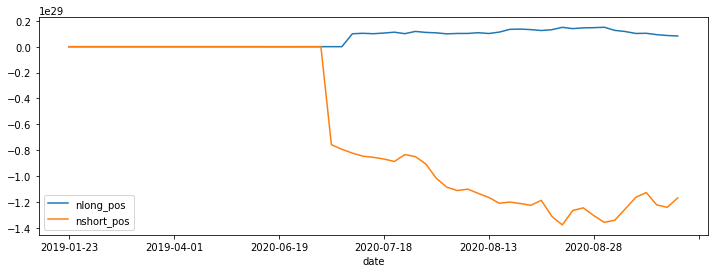

In [121]:
metrics[['nlong_pos', 'nshort_pos']].plot(figsize=(12, 4));

In [122]:
start = str(returns.index.min().year)
end = str(returns.index.max().year + 1)

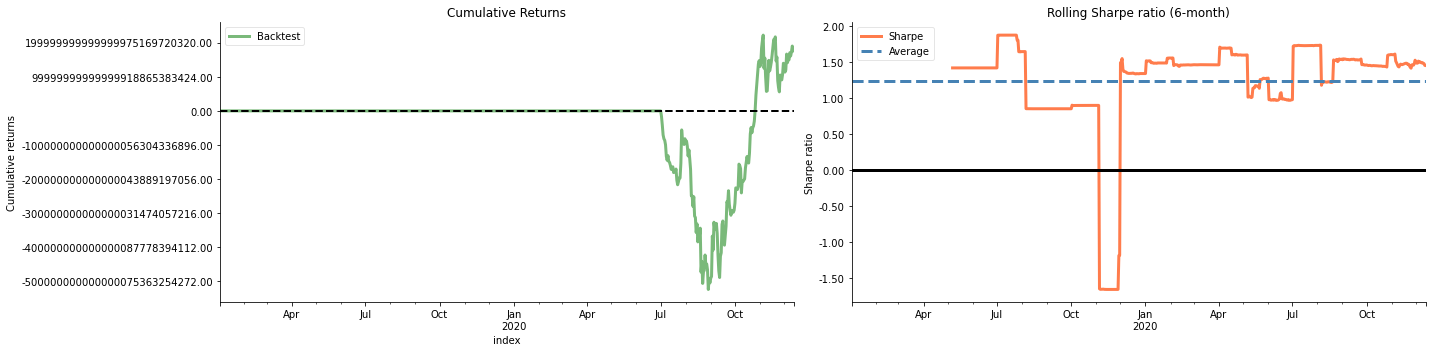

In [128]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5))
pf.plotting.plot_rolling_returns( returns, ax=axes[0])
axes[0].set_title('Cumulative Returns')
pf.plotting.plot_rolling_sharpe(returns, ax=axes[1])
sns.despine()
fig.tight_layout();

In [129]:
import pandas_datareader.data as web

In [130]:
benchmark = web.DataReader('SP500', 'fred',
                           start=start,
                           end=end).squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [131]:
pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions,
                          benchmark_rets=benchmark.loc[returns.index],
                          estimate_intraday=False)

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: DatetimeIndex(['2019-01-05 00:00:00+00:00', '2019-01-06 00:00:00+00:00',\n               '2019-01-12 00:00:00+00:00', '2019-01-13 00:00:00+00:00',\n               '2019-01-19 00:00:00+00:00',\n               ...\n               '2020-11-29 00:00:00+00:00', '2020-12-05 00:00:00+00:00',\n               '2020-12-06 00:00:00+00:00', '2020-12-12 00:00:00+00:00',\n               '2020-12-13 00:00:00+00:00'],\n              dtype='datetime64[ns, UTC]', name='index', length=204, freq=None). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"